# UCI DH MTB Race Analysis
## Setup
#### Import Libraries

If you do not have these libraries available, you should install them using `pip`

In [1]:
import pandas as pd
import numpy as np
from decimal import Decimal, ROUND_HALF_UP
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import math
from colour import Color
from cycler import cycler

Widen display area to prevent column wrapping, and always show all columns for debug

In [2]:
pd.set_option('display.width', 2000)
pd.set_option('display.max_columns', None)

## Config

Analysis choices

Race:
1. Losinj
1. Fort William
1. Leogang
1. Val di Sole
1. Vallnord
1. Mont-Sainte-Anne
1. La Bresse

Gender:
- m: Men
- f: Women

Other:
- `topX`: How many racers are we interested in comparing?
- `splits`: How many timing splits are there in the race?

In [3]:
race = 1
gender = 'm'
topX = 20
splits = 5 # Could detect this from dataset? @todo

List of season races to build the filename 

In [4]:
races = [
    'losinj',
    'fortbill',
    'leogang',
    'valdisole',
    'vallnord',
    'msa',
    'labresse',
]
racename = races[race-1]
raceName = racename.title()

#### Import Data

Read the CSV file, then clear out the DNF/DNS entries

In [5]:
event = 'dh'
filePrefix = event + '_' + str(race) + '_' + raceName + '_' + gender
file = filePrefix + '.results.csv'
df = pd.read_csv( file, index_col=0 )
df = df.dropna() # remove DNF/DNS

dfm = pd.read_csv( filePrefix + '.merged.csv', index_col=0 )

Do some input checks and error corrects

In [6]:
if topX > len(df):
    topX = len(df)

Peek at the data if we wish to make sure it looks correct 

In [7]:
display( df.head() )
# display( df.tail() )
# display( dfr.head() )
# display( dfm.head() )

,bib,id,name,rank,speed,split1,split2,split3,split4,split5,start,start_rev,status,uci,split1_rank,split1_vs_best,split1_vs_winner,split2_rank,split2_vs_best,split2_vs_winner,split2_sector,split2_sector_rank,split2_sector_vs_best,split2_sector_vs_winner,split3_rank,split3_vs_best,split3_vs_winner,split3_sector,split3_sector_rank,split3_sector_vs_best,split3_sector_vs_winner,split4_rank,split4_vs_best,split4_vs_winner,split4_sector,split4_sector_rank,split4_sector_vs_best,split4_sector_vs_winner,split5_rank,split5_vs_best,split5_vs_winner,split5_sector,split5_sector_rank,split5_sector_vs_best,split5_sector_vs_winner,speed_ms,speed_ms_vs_best,speed_rank,points
0,1,1001,GWIN Aaron,1,47.21,20.810,52.860,80.785,116.514,139.193,63,2,Finished,10006516663,6.0,0.197,0.000,1.0,0.000,0.000,32.050,1.0,0.000,0.000,1.0,0.000,0.000,27.925,5.0,0.174,0.000,1.0,0.000,0.000,35.729,3.0,0.422,0.000,1.0,0.000,0.000,22.679,11.0,0.782,0.000,13.113889,0.000000,19.0,200.0
1,13,1013,SHAW Luca,2,49.60,20.613,54.162,82.787,118.094,139.991,60,5,Finished,10008813442,1.0,0.000,-0.197,3.0,1.302,1.302,33.549,6.0,1.499,1.499,6.0,2.002,2.002,28.625,11.0,0.874,0.700,3.0,1.580,1.580,35.307,1.0,0.000,-0.422,2.0,0.798,0.798,21.897,1.0,0.000,-0.782,13.777778,0.000000,1.0,160.0
2,16,1016,LUCAS Dean,3,48.00,20.680,53.964,81.870,117.830,140.328,64,1,Finished,10008103322,2.0,0.067,-0.130,2.0,1.104,1.104,33.284,3.0,1.234,1.234,2.0,1.085,1.085,27.906,4.0,0.155,-0.019,2.0,1.316,1.316,35.960,6.0,0.653,0.231,3.0,1.135,1.135,22.498,8.0,0.601,-0.181,13.333333,0.444444,9.0,140.0
3,19,1019,BLENKINSOP Samuel,4,49.55,21.224,54.699,82.891,118.749,141.107,61,4,Finished,10004485929,16.0,0.611,0.414,6.0,1.839,1.839,33.475,5.0,1.425,1.425,7.0,2.106,2.106,28.192,7.0,0.441,0.267,4.0,2.235,2.235,35.858,4.0,0.551,0.129,4.0,1.914,1.914,22.358,5.0,0.461,-0.321,13.763889,0.013889,2.0,125.0
4,34,1034,NORTON Dakotah,5,47.50,20.904,54.898,83.172,119.061,141.821,43,22,Finished,10010038167,9.0,0.291,0.094,9.0,2.038,2.038,33.994,12.0,1.944,1.944,9.0,2.387,2.387,28.274,8.0,0.523,0.349,5.0,2.547,2.547,35.889,5.0,0.582,0.160,5.0,2.628,2.628,22.760,14.0,0.863,0.081,13.194444,0.583333,15.0,110.0


## Functions

Function that converts a time in seconds in to a timedelta, used later on

In [8]:
def convertToDelta( timestring ):
    timestring = str(timestring)

    if ":" not in timestring:
        timestring = str(Decimal( timestring ).quantize( Decimal('.001' ), rounding=ROUND_HALF_UP ))
        timestring = "0:" + timestring

    timestring = "0:" + timestring

    return pd.to_timedelta( timestring )

Function to format a timedelta for display `hh:mm:ss.xxx` (drop the days)

In [9]:
def formatDelta( time ):
    return ':'.join(str(time).split(':')[1:3])[:-3]

## Charts

### Timing Gaps

Function defintion that draws all the scatter graphs for each split and sector time.

Accepts string reference to a column in the dataframe, and the chart title

Within the function, a few things are calculated

> Podium: 1st 2nd 3rd place finishers are highlighted throughout each chart by gold, silver, bronze dot respectively

In [10]:
def drawScatter( df2, col, title, timeCol=False, minX=False, maxX=False, color='cornflowerblue', xlabel='Gap (seconds)', labelPosOffsetX=0 ):
    pltY = 3.5 * ( topX / 10 )
    pltX = 2.5 * ( topX / 10 )
    plt.subplots(figsize=(pltX,pltY))
    
    if False == minX:
        minX = df2[col].max()
    if False == maxX:
        maxX = -.5
#         maxX = df2[col].max()# - (df2[col].min()*.1)  #-.5
#         display( maxX )
    
    # Build list of plot colors and sizes, then alter those entries for final 1,2,3 finishers
    colors = [color]*(len(df2[col]))
    colors[int(df2.loc[df2['rank'] == 1].index.values)] = "gold"
    colors[int(df2.loc[df2['rank'] == 2].index.values)] = "silver"
    colors[int(df2.loc[df2['rank'] == 3].index.values)] = "peru"
    sizes = [40]*(len(df2[col]))
    sizes[int(df2.loc[df2['rank'] == 1].index.values)] = 100
    sizes[int(df2.loc[df2['rank'] == 2].index.values)] = 100
    sizes[int(df2.loc[df2['rank'] == 3].index.values)] = 100
    
    # Build the chart
    plot = sns.regplot( y=df2.index.values[0:topX], x=df2[col][0:topX], fit_reg=False, scatter_kws={"color":colors, "s":sizes} )
    plot.invert_yaxis()
    plot.invert_xaxis()
    plt.xlim( minX, maxX )

    # Format the chart
    sns.despine()
    plot.yaxis.set_visible(False)
    plot.set_frame_on(False)
    sns.set_style('whitegrid')
    plot.grid( color='#EEEEEE', linewidth=1.0 )
    plot.set( title=title, xlabel=xlabel )
#     plt.tight_layout()

    # Reference column to display 1st place actual time rather than difference
    coln = col[:6] + ( "_sector" if col[7:9] != "vs" else "" ) if timeCol == False else False

    # Add labels to data points
    for row in range( 0, topX ):
        label = df2.name[row] + " " + ( formatDelta( convertToDelta( df2[coln][row] ) ) if row==0 and coln else "+" + str(df2[col][row])[:5] )
        x = df2[col][row] + labelPosOffsetX
        y = df2.index.values[row] + 0.15
        plot.text( x, y, label, horizontalalignment='right', size='small' )

> X-Axis: Standardised across all charts for readibility, calculated as time gap between slowest person in the included dataset and first place at the finish 

In [35]:
#
minX = math.ceil(df['split' + str(splits) + '_vs_winner'][topX-1])
#     minX = math.ceil( ( df['split' + str(splits) + '_vs_winner'][topX-1] ) / 10 ) * 10
labelPosOffsetX = ( ( .2 if topX >= 20 else 1 ) * ( math.ceil( topX / 2 / 10 ) ) )

Iterate over the number of `splits` and draw two timing charts on each loop, except for the first where split and sector would be the same

> Split: Time elapsed since start of race run

> Sector: Time elapsed since last split time

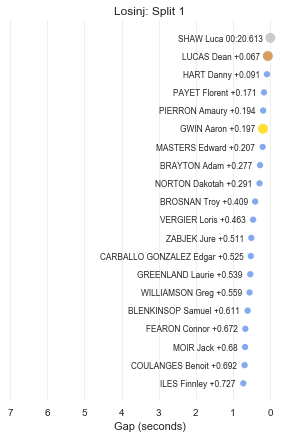

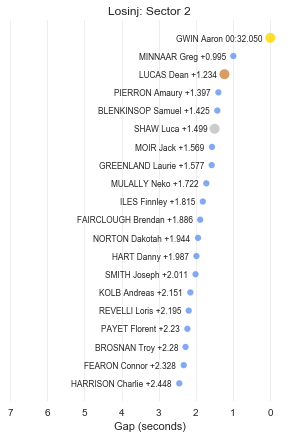

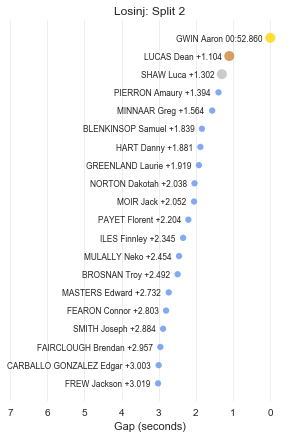

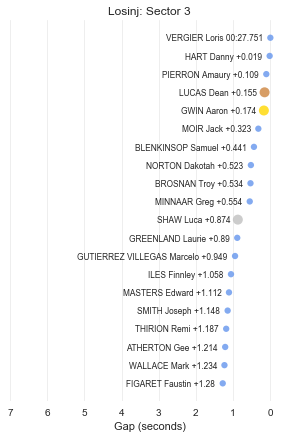

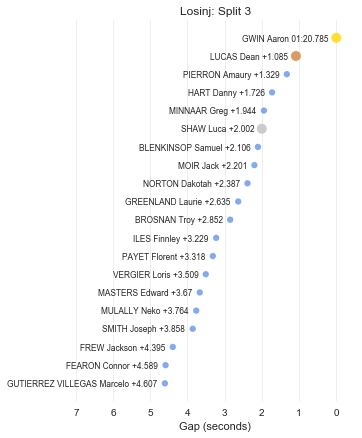

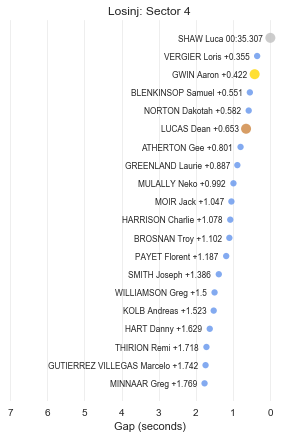

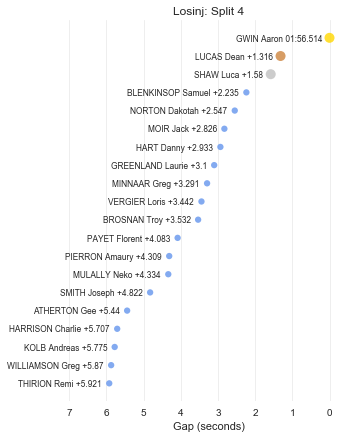

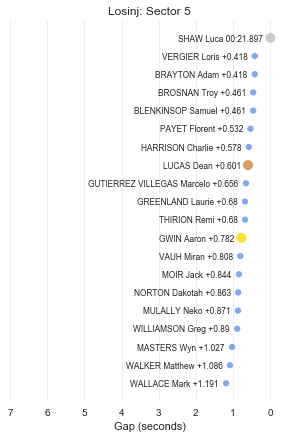

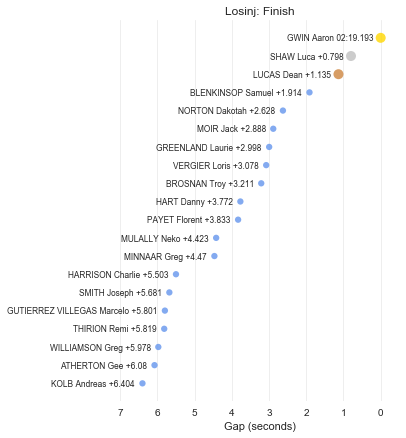

In [56]:
for i in range( 1, splits+1 ):
    x = str(i)
    split = 'split' + x

    if i > 1:
        col2 = split + '_sector_vs_best'
        dfSector = df.sort_values( col2, ascending=True ).reset_index( drop=True )
        drawScatter( dfSector, col2, raceName + ': Sector ' + x, minX=minX, labelPosOffsetX=labelPosOffsetX )

    col = split + '_vs_best'
    dfSplit = df.sort_values(col, ascending=True).reset_index(drop=True)
    drawScatter( dfSplit, col, ( raceName + ': Split ' + x if i < splits else raceName + ': Finish' ), minX=minX, labelPosOffsetX=labelPosOffsetX )

### Position Consistency Heatmaps

Calculating chart size best fit

In [13]:
pltX = 1.4 * splits
pltY = 4 * ( topX / 10 )

Build list of riders for Y-axis, adding their finishing position next to them 

In [14]:
ylabels = [ j + ": " + str(i+1) for i, j in enumerate(df.name[:topX]) ]

Build data subset of ranking for each timing sector, then visualize consistency on a heatmap

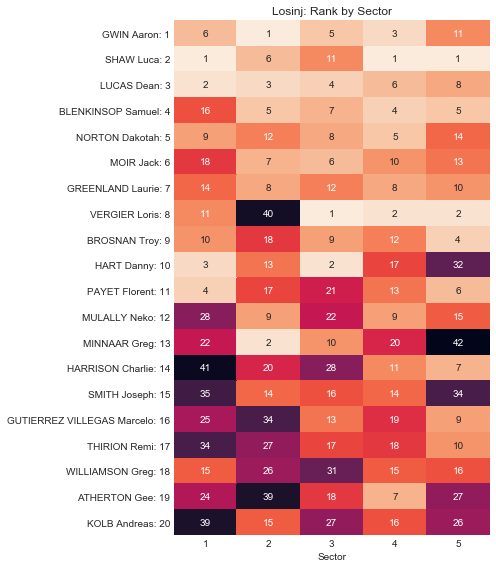

In [15]:
dfSectorRank = df[['split1_rank', 'split2_sector_rank', 'split3_sector_rank', 'split4_sector_rank', 'split5_sector_rank']][:topX].copy()

plt.figure(figsize=(pltX, pltY))
map = sns.heatmap(dfSectorRank, annot=True, yticklabels=ylabels, xticklabels=range(1,splits+1), cmap=sns.cm.rocket_r, cbar=False)
plt.xlabel( 'Sector' )
plt.title( raceName + ': Rank by Sector' )
plt.tight_layout()

Same as before but this time ranking for each race split, then visualize on a heatmap

On this heatmap, each rider represented will ideally gradually move darker to lighter left to right as their position improves toward the finish, unless they're winning from the start in which case it would stay the same (like Gwin from 2 onward)

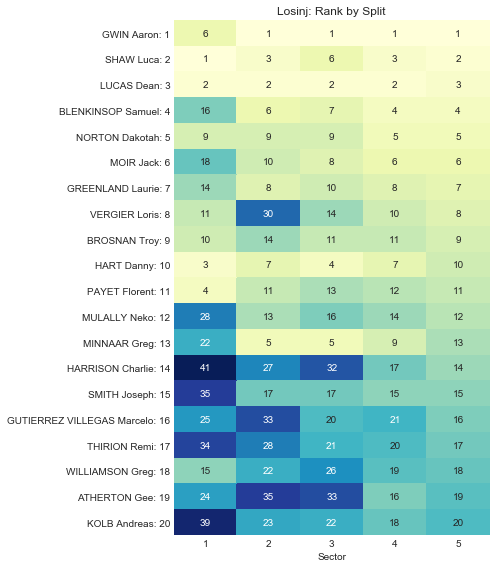

In [16]:
# Prepare data
dfSplitRank = df[['split1_rank', 'split2_rank', 'split3_rank', 'split4_rank', 'split5_rank']][:topX].copy()

# Configure and build heatmap
plt.figure(figsize=(pltX, pltY))
sns.heatmap( dfSplitRank, annot=True, yticklabels=ylabels, xticklabels=range(1,splits+1), cmap="YlGnBu", cbar=False )
plt.xlabel( 'Sector' )
plt.title( raceName + ': Rank by Split' )
plt.tight_layout()
# plt.savefig( 'heatmap_split.png', dpi=72 )

### Position Change Line Chart

This chart contains the same information as the second heatmap above but more clearly shows how riders changed positions as the race progressed until their final finishing place

We start by building up some lists of colors and lines styles to make the chart a little easier to read

In [17]:


# color1 = Color( 'gold' )
color1 = Color( '#2171b5' )
# color2 = Color( 'red' )
color2 = Color( '#bdd7e7' )
colorSat = 0.8
color1.saturation = colorSat
color2.saturation = colorSat
colors = list( color1.range_to( color2 , 5) )
# colors = list( 4* [ i.web for i in colors ] )
colors = list( np.repeat( [ i.web for i in colors ], 4 ) )
lines = 5*['-', '--', '-.', ':']
lines = 20*['-']

colors[int(df.loc[df['rank'] == 1].index.values)] = "gold"
colors[int(df.loc[df['rank'] == 2].index.values)] = "silver"
colors[int(df.loc[df['rank'] == 3].index.values)] = "peru"

# from random import shuffle
# colors = list( color1.range_to( color2 , 20) )
# colors = ( list( [ i.web for i in colors ] ) )
# shuffle( colors )

display( colors )


['gold',
 'silver',
 'peru',
 '#1572c1',
 '#2391e7',
 '#2391e7',
 '#2391e7',
 '#2391e7',
 '#51abec',
 '#51abec',
 '#51abec',
 '#51abec',
 '#80c4f1',
 '#80c4f1',
 '#80c4f1',
 '#80c4f1',
 '#aedbf6',
 '#aedbf6',
 '#aedbf6',
 '#aedbf6']

These lists are then used to build a color map and a bunch of other stuff calculated and configured before finally displayin the line chart

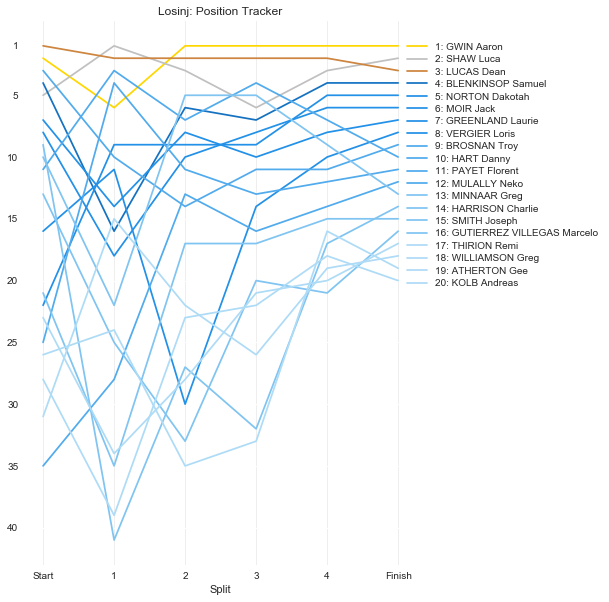

In [18]:
data = df[['start_rev', 'split1_rank', 'split2_rank', 'split3_rank', 'split4_rank', 'split5_rank']][:topX].copy().T

mpl.style.use('seaborn')

cyc = cycler('color', colors) + cycler('linestyle', lines)
mpl.rcParams['axes.prop_cycle'] = cycler(cyc)

pltX = 1.4 * splits
pltY = 5 * ( topX / 10 )

fig = plt.figure( figsize=(pltX, pltY) )
plt.plot( data, label=True )
ax = plt.gca()
ax.invert_yaxis()
ax.set_facecolor('xkcd:white')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# plt.box(on=None)


plt.xlabel( 'Split' )
plt.title( raceName + ': Position Tracker' )

maxY = int(dfSplitRank['split1_rank'].max()+1)
plt.yticks( [1]+list(range( 5, maxY, 5 )), [1]+list(range( 5, maxY, 5 )) )
xlabels = ['Start'] + [ str(i) for i in range( 1, splits ) ] + ['Finish']
plt.xticks( range( 0, splits+1 ), xlabels )
plt.grid( True, which='major', axis='y' )
plt.grid( True, which='major', axis='x', color='#EEEEEE' )

handles, labels = ax.get_legend_handles_labels()
# labelY = df['name'][:topX].values.tolist()
legendlabels = [ str(i+1) + ": " + j for i, j in enumerate(df.name[:topX]) ]
ax.legend( handles, legendlabels, loc=1, labelspacing=0.3445, bbox_to_anchor=(1.49, 0.977)) #, handletextpad=1

plt.show()

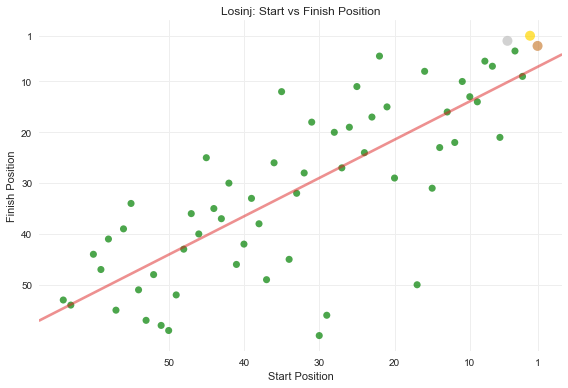

In [19]:
col = 'rank'
df2 = df.sort_values(col, ascending=True)
df2 = df2.reset_index(drop=True)

color = "green"
colors = [color]*(len(df2[col]))
colors[int(df2.loc[df2['rank'] == 1].index.values)] = "gold"
colors[int(df2.loc[df2['rank'] == 2].index.values)] = "silver"
colors[int(df2.loc[df2['rank'] == 3].index.values)] = "peru"
sizes = [50]*(len(df2[col]))
sizes[int(df2.loc[df2['rank'] == 1].index.values)] = 100
sizes[int(df2.loc[df2['rank'] == 2].index.values)] = 100
sizes[int(df2.loc[df2['rank'] == 3].index.values)] = 100

plot = sns.regplot( df2['start_rev'], df2['rank'], scatter_kws={"s": sizes, "alpha": 0.7, "color": colors}, line_kws={'color': '#DD2222', "alpha": 0.5}, ci=None)

# Format the chart
sns.despine()
plot.set_frame_on(False)
sns.set_style('whitegrid')
plot.grid( color='#EEEEEE', linewidth=1.0 )
plot.set( title=raceName + ': Start vs Finish Position', xlabel='Start Position', ylabel='Finish Position' )

plot.invert_yaxis()
plot.invert_xaxis()
tick = [1]+list(range( 10, len(df2), 10 ))
plt.yticks( tick, tick )
plt.xticks( tick, tick )
plt.tight_layout()


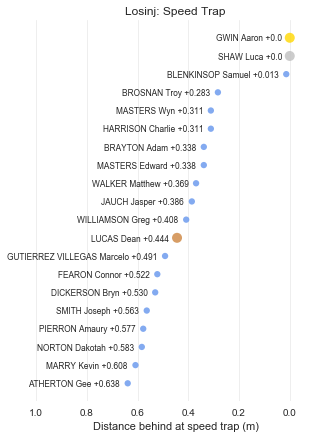

In [20]:
col = 'speed_ms_vs_best'
df2 = df.sort_values(col, ascending=True)
df2 = df2.reset_index(drop=True)
drawScatter( df2, col, raceName + ': Speed Trap', timeCol='speed_ms_vs_best', xlabel='Distance behind at speed trap (m)', minX=1, maxX=-.1, labelPosOffsetX=.03 )

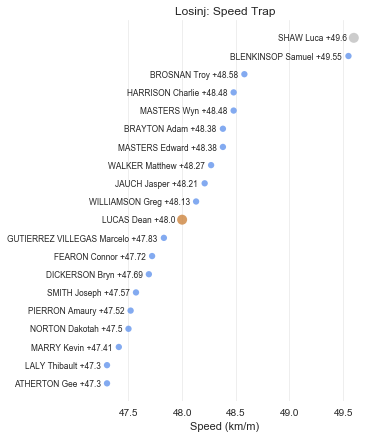

In [21]:
col = 'speed'
df2 = df.sort_values(col, ascending=False)
df2 = df2.reset_index(drop=True)
drawScatter( df2, col, raceName + ': Speed Trap', timeCol='speed', xlabel='Speed (km/m)', minX=df2.head(topX).speed.min()-.2, maxX=df2.speed.max()+.1, labelPosOffsetX=-.06 )

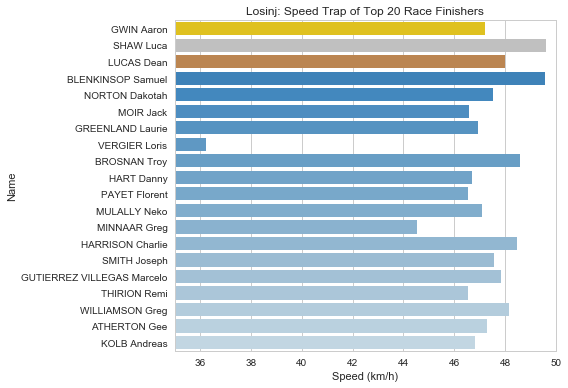

In [22]:
col = 'rank'
df2 = df.sort_values(col, ascending=True)
df2 = df2.reset_index(drop=True)

color1 = Color( '#2171b5' )
color2 = Color( '#bdd7e7' )
colors = list( color1.range_to( color2 , topX) )
colors = [ i.web for i in colors ]
colors[int(df2.loc[df2['rank'] == 1].index.values)] = "gold"
colors[int(df2.loc[df2['rank'] == 2].index.values)] = "silver"
colors[int(df2.loc[df2['rank'] == 3].index.values)] = "peru"
cyc = cycler('color', colors) + cycler('linestyle', lines)
mpl.rcParams['axes.prop_cycle'] = cycler(cyc)

plot = sns.barplot( df2['speed'][:20], df2.name[:20])
plot.set( title=raceName + ': Speed Trap of Top ' + str(topX) + ' Race Finishers', xlabel='Speed (km/h)', ylabel='Name' )

minX = math.floor( df2.speed[:topX].min()-1 )
maxX = math.ceil( df2.speed[:topX].max() )
plt.xlim( minX, maxX )
plt.tight_layout()

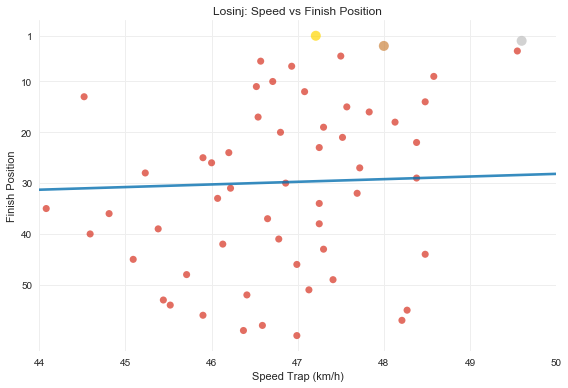

In [23]:
col = 'rank'
df2 = df.sort_values(col, ascending=True)
df2 = df2.reset_index(drop=True)

color = "#d7301f"
colors = [color]*(len(df2[col]))
colors[int(df2.loc[df2['rank'] == 1].index.values)] = "gold"
colors[int(df2.loc[df2['rank'] == 2].index.values)] = "silver"
colors[int(df2.loc[df2['rank'] == 3].index.values)] = "peru"
sizes = [50]*(len(df2[col]))
sizes[int(df2.loc[df2['rank'] == 1].index.values)] = 100
sizes[int(df2.loc[df2['rank'] == 2].index.values)] = 100
sizes[int(df2.loc[df2['rank'] == 3].index.values)] = 100

plot = sns.regplot( df2['speed'], df2['rank'], ci=None, line_kws={'color': '#0570b0', "alpha": 0.8}, scatter_kws={"s": sizes, "alpha": 0.7, "color": colors})
plot.invert_yaxis()
plot.set_frame_on(False)
plt.xlim( 44, 50 )
plot.set( title=raceName + ': Speed vs Finish Position', xlabel='Speed Trap (km/h)', ylabel='Finish Position' )
tick = [1]+list(range( 10, len(df2), 10 ))
plt.yticks( tick, tick )
plt.grid( True, which='major', axis='y', color='#EEEEEE' )
plt.grid( True, which='major', axis='x', color='#EEEEEE' )
plt.tight_layout()

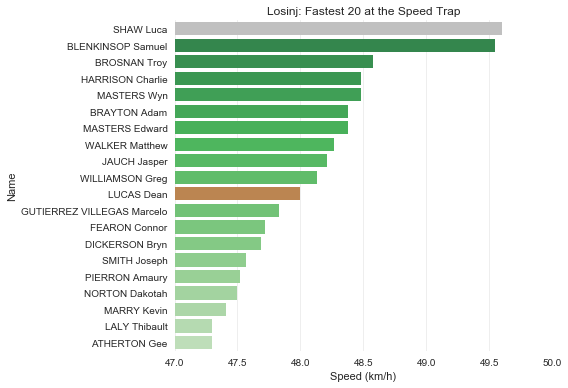

In [24]:
col = 'speed'
df2 = df.sort_values(col, ascending=False)
df2 = df2.reset_index(drop=True)

color1 = Color( '#238b45' )
color2 = Color( '#bae4b3' )
colors = list( color1.range_to( color2 , topX) )
colors = [ i.web for i in colors ]
first = int(df2.loc[df2['rank'] == 1].index.values)
second = int(df2.loc[df2['rank'] == 2].index.values)
third = int(df2.loc[df2['rank'] == 3].index.values)
if first <= topX:
    colors[first] = "gold"
if second <= topX:
    colors[second] = "silver"
if third <= topX:
    colors[third] = "peru"
cyc = cycler('color', colors) + cycler('linestyle', lines)
mpl.rcParams['axes.prop_cycle'] = cycler(cyc)

plot = sns.barplot( df2.speed[:topX], df2.name[:topX])
plot.set( title=raceName + ': Fastest ' + str(topX) + ' at the Speed Trap', xlabel='Speed (km/h)', ylabel='Name' )
plot.set_frame_on(False)
minX = math.floor( df2.speed[:topX].min() )
maxX = math.ceil( df2.speed[:topX].max() )
plt.xlim( minX, maxX )
plt.grid( True, which='major', axis='x', color='#EEEEEE' )
plt.tight_layout()

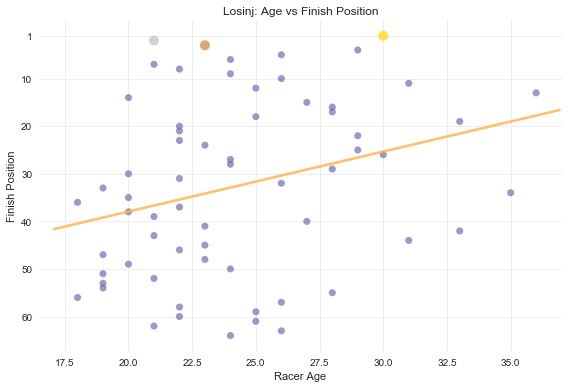

In [25]:
col = 'rank'
df2 = dfm.sort_values(col, ascending=True)
df2 = df2.reset_index(drop=True)

color = "#756bb1"
colors = [color]*(len(df2[col]))
colors[int(df2.loc[df2['rank'] == 1].index.values)] = "gold"
colors[int(df2.loc[df2['rank'] == 2].index.values)] = "silver"
colors[int(df2.loc[df2['rank'] == 3].index.values)] = "peru"
sizes = [50]*(len(df2[col]))
sizes[int(df2.loc[df2['rank'] == 1].index.values)] = 100
sizes[int(df2.loc[df2['rank'] == 2].index.values)] = 100
sizes[int(df2.loc[df2['rank'] == 3].index.values)] = 100

plot = sns.regplot( df2['Age'], df2['rank'], ci=None, line_kws={'color': '#feb24c', "alpha": 0.8}, scatter_kws={"s": sizes, "alpha": 0.7, "color": colors})
plot.invert_yaxis()
plt.xlim( 16.5, 37 )
plot.set_frame_on(False)
plot.set( title=raceName + ': Age vs Finish Position', xlabel='Racer Age', ylabel='Finish Position' )
tick = [1]+list(range( 10, len(df2), 10 ))
plt.yticks( tick, tick )
plt.grid( True, which='major', axis='y', color='#EEEEEE' )
plt.grid( True, which='major', axis='x', color='#EEEEEE' )
plt.tight_layout()

In [26]:
# dfm.groupby( ['Nation'] )[['bib']].count().sort_values( 'bib', ascending=False )

# dfm.groupby( ['Nation'] )[['points']].sum().sort_values( 'points', ascending=False )

dfa = dfm.groupby( ['Nation'] ).agg({
    'points': ['sum', 'mean']
    , 'bib': 'count'
    , 'Age': ['min', 'max', 'mean']
}).sort_values( [('points','mean')], ascending=False )
dfa[('points','mean')] = round(dfa[('points','mean')], 2)
dfa[('Age','mean')] = round(dfa[('Age','mean')], 2)

# col = [('bib','count')]
# dfa[col] = dfa[dfa[col] > 1][col]
# dfa = dfa.dropna()
dfa = dfa.reset_index(drop=False)

dfa

Nation points           bib Age           
             sum    mean count min max   mean
0     USA  590.0  118.00     5  20  30  24.40
1     AUS  377.0   75.40     6  19  25  23.17
2     RSA   60.0   60.00     1  36  36  36.00
3     NZL  209.0   41.80     6  26  31  28.00
4     GBR  473.0   39.42    12  18  33  24.50
5     FRA  397.0   33.08    14  19  33  24.21
6     COL   58.0   29.00     2  23  28  25.50
7     AUT   57.0   28.50     2  22  23  22.50
8     SLO   57.0   28.50     2  22  35  28.50
9     CAN   88.0   22.00     4  18  22  19.75
10    ESP   37.0   18.50     2  22  29  25.50
11    ITA   44.0   14.67     3  20  22  21.33
12    SUI   26.0   13.00     2  22  25  23.50
13    BRA   10.0   10.00     1  19  19  19.00
14    NOR    8.0    8.00     1  19  19  19.00
15    GER    4.0    4.00     1  26  26  26.00

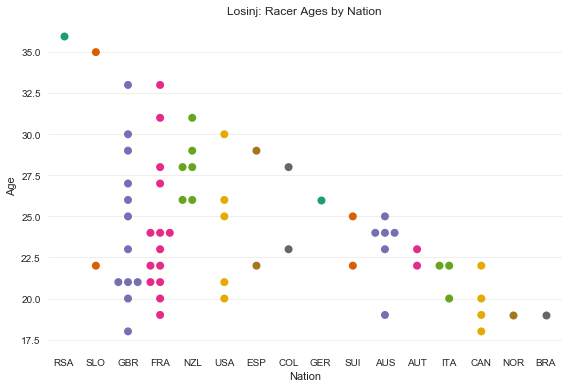

In [27]:
plot = sns.swarmplot( x='Nation', y='Age', data=dfm.sort_values('Age', ascending=False), palette='Dark2', size=8 )
# sns.countplot( x='Nation', data=dfm.sort_values('Nation', ascending=True), palette='Blues_d' )
plot.set_frame_on(False)
plt.title(raceName + ': Racer Ages by Nation')
plt.grid( True, which='major', axis='y', color='#EEEEEE' )
plt.tight_layout()

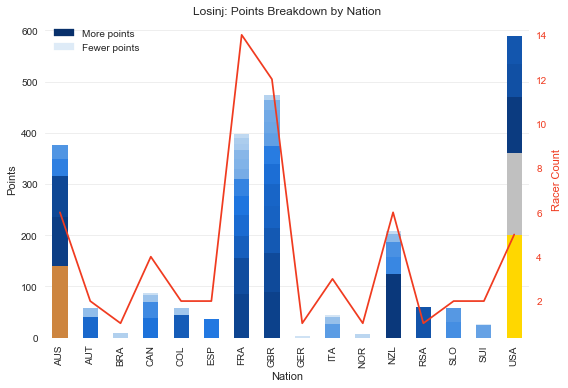

In [28]:
dfPoints = dfm[['name', 'Nation', 'points']].copy().dropna()
dfPivot = dfPoints.pivot( index='Nation', columns='name', values='points' ).fillna(0)
dfPivot = dfPivot[dfm[:60]['name']]
dfb = dfa.sort_values( ['Nation'], ascending=True )

color1 = Color( '#08306b' )
color2 = Color( '#deebf7' )
colors = list( color1.range_to( color2 , len(df) ) )
colors = [ i.web for i in colors ]
# colors[list(dfPivot.keys()).index( df2.loc[df2['rank'] == 1]['name'][0] )] = "gold"
colors[0] = 'gold'
colors[1] = 'silver'
colors[2] = 'peru'

ax = dfPivot.plot.bar( stacked=True, color=colors )
leg1 = mpatches.Patch(color='#08306b', label='More points')
leg2 = mpatches.Patch(color='#deebf7', label='Fewer points')
ax.legend_.remove()
plt.legend( handles=[leg1, leg2])
plt.title(raceName + ': Points Breakdown by Nation')
ax.set_ylabel( 'Points' )

ax2 = ax.twinx()
ax2.plot( dfb['Nation'], dfb['bib']['count'], '#f03b20' )
ax2.set_ylabel('Racer Count', color='#f03b20')
ax2.tick_params('y', colors='#f03b20', zorder='0')

ax.grid( False, which='major', axis='y', color='#EEEEEE' )
ax2.grid( False, which='major', axis='y' )
ax.grid( False, which='major', axis='x' )
ax2.grid( False, which='major', axis='x' )

ax.set_frame_on(False)
ax2.set_frame_on(False)
plt.tight_layout()

--- 

## Credits

### Author: Dominic Wrapson


> **@domwrap**
<br>
<a href="https://github.com/domwrap/"><img src="https://png.icons8.com/material/24/000000/github-2.png"></a>
<a href="https://stackoverflow.com/users/2154487/domwrap"><img src="https://png.icons8.com/material/24/000000/stackoverflow.png"></a>
<a href="https://www.linkedin.com/in/domwrap"><img src="https://png.icons8.com/material/24/000000/linkedin.png"></a>
<a href="https://notebooks.azure.com/domwrap"><img src="https://png.icons8.com/material/24/000000/windows8.png"></a>
<a href="https://www.instagram.com/domwrap"><img src="https://png.icons8.com/ios-glyphs/24/000000/instagram-new.png"></a>
<a href="http://twitter.com/domwrap"><img src="https://png.icons8.com/material/24/000000/twitter.png"></a>
<a href="https://medium.com/@domwrap"><img src="https://png.icons8.com/material/24/000000/medium-logo.png"></a>
>
> <img src="https://png.icons8.com/material/24/000000/home.png"> http://domwrap.me
>
><img src="https://png.icons8.com/material/24/000000/cycling-mountain-bike.png"> [Hwulex](https://www.pinkbike.com/u/Hwulex/)


---

#### Special Thanks

Mark Shilton for the inspiration
- http://lookatthestats.blogspot.ca
- https://plus.google.com/+MarkShilton
- https://dirtmountainbike.com/author/mrgeekstats


<a href="https://icons8.com">Icon pack by Icons8</a>